In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class, get_dataloader
from src.model.sequence_classification.trainer import SequenceClassificationTrainer

import re
from typing import List, Dict
    

import warnings
warnings.filterwarnings("ignore")

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!mkdir logs
model_name = "Finetuning"
dataset_name = "RAFT-ADE"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

mkdir: cannot create directory ‘logs’: File exists


## Get data

In [6]:
ade_corpus_dataset = load_dataset(
    "ade_corpus_v2", 
    name= "Ade_corpus_v2_classification",
    cache_dir= "/Data/pedro.silva"
)

Generating train split:   0%|          | 0/23516 [00:00<?, ? examples/s]

In [9]:
train_dataset = ade_corpus_dataset['train']

In [10]:
classes = np.unique(train_dataset['label'], return_counts=True)
classes

(array([0, 1]), array([16695,  6821]))

In [11]:
classes_names = ["not ADE related", "ADE related"]

In [12]:
num_classes = len(classes[0])

In [13]:
num_classes

2

In [44]:
df = train_dataset.to_pandas()


In [69]:
proportion = df['label'].value_counts()/len(df)

In [70]:
proportion[0]

0.7099421670352101

,text,label
0,Intravenous azithromycin-induced ototoxicity.,1
1,"Immobilization, while Paget's bone disease was...",1
2,Unaccountable severe hypercalcemia in a patien...,1
3,METHODS: We report two cases of pseudoporphyri...,1
4,METHODS: We report two cases of pseudoporphyri...,1
...,...,...
23511,"At autopsy, the liver was found to be small, s...",0
23512,"Physical exam revealed a patient with aphasia,...",0
23513,At the time when the leukemia appeared seven o...,0
23514,The American Society for Regional Anesthesia a...,0


In [97]:
train_size = 0.7
def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float,
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    
    if isinstance(dataset, pd.DataFrame):
        df = dataset

    else:
        df = dataset.to_pandas()
    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = df.query(f"label == {label}")


    
    train_data = {
        'label': [],
        'text': []
    }

    validation_data = {
        "label" : [],
        "text": []
    }

    class_proportion = df['label'].value_counts()/len(df)

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])

        if isinstance(train_size, int):
            size = int(class_proportion[label] * train_size)
            
        else:
            size = int(train_size * n)

        train_data['text'] += df.query(f"label == {label}")\
            [0:size]\
            ['text']\
            .to_list()
        
        train_data['label'] += [label]*size
        
        validation_data['text'] +=df.query(f"label == {label}")\
            [size:]\
            ['text']\
            .to_list()
        
        validation_data['label'] += [label]* (n-size)

    return train_data, validation_data

## 20 shots

In [99]:
n_shots = 20
train, validation_test_dataset = stratified_train_test_split(
    train_dataset,
    classes,
    n_shots
)

In [125]:
val, test = stratified_train_test_split(
    pd.DataFrame(validation_test_dataset),
    classes,
    0.5
)

In [126]:
val = pd.DataFrame(val).sample(n = 300).to_dict('list')
test = pd.DataFrame(test).sample(n = 1000).to_dict('list')

In [127]:
np.unique(train['label'], return_counts=True)

(array([0, 1]), array([14,  5]))

In [128]:
np.unique(val['label'],return_counts=True)

(array([0, 1]), array([209,  91]))

In [129]:
np.unique(test['label'],return_counts=True)

(array([0, 1]), array([703, 297]))

## Focal Loss Fn

In [130]:
_, class_counts = np.unique(
    train['label'],
    return_counts=True,
)

alpha = len(train['label'])/class_counts

# ------------ val -----------------------------------

_, class_counts_val = np.unique(
    val['label'],
    return_counts=True,
)
alpha_val = len(val['label'])/class_counts_val

# ----------- test ------------------------------------

_, class_counts_test = np.unique(
    test['label'],
    return_counts=True,
)
alpha_test = len(test['label'])/class_counts_test

In [131]:
alpha, alpha_val, alpha_test

(array([1.35714286, 3.8       ]),
 array([1.4354067, 3.2967033]),
 array([1.42247511, 3.36700337]))

In [132]:
from src.utils import FocalLoss
loss_fn = FocalLoss(
    gamma= 1,
    alpha= alpha,
    device = "cuda"
)

In [143]:
bert = AutoModelForSequenceClassification\
    .from_pretrained(
        "bert-base-uncased", 
        num_labels = num_classes,
        cache_dir = "/Data/pedro.silva"    
    )\
    .to(device)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", cache_dir = "/Data/pedro.silva"  )

trainer = SequenceClassificationTrainer(
    bert,
    num_classes
)
n_shots = len(train['text'])

train_dataloader = get_dataloader(
    train['text'],
    train['label'],
    tokenizer,
    n_shots= n_shots,
    equalize_class= False,
    num_classes= num_classes,
)


val_dataloader = get_dataloader(
    val['text'],
    val['label'],
    tokenizer,
    n_shots = 300,
    num_classes=num_classes,
    equalize_class=False,
)


history = trainer.compile(
    train_dataloader,
    val_dataloader,
    loss_fn= loss_fn,
    evaluation_fn= binary_f1_score,
    n_epochs=30
)


f1: 0.3548387289047241
tensor([[198,  11],
        [ 69,  22]], device='cuda:0')


Text(0, 0.5, 'F1 score')

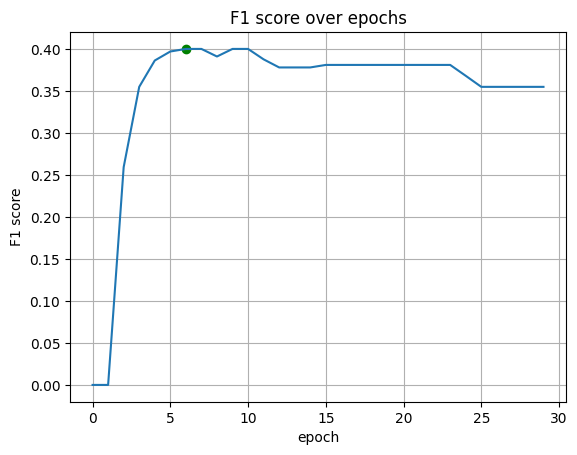

In [144]:
plt.plot(history['val_f1'])

plt.scatter(
    np.argmax(history['val_f1']),
    np.max(history['val_f1']),
    label = f"f1 = {np.max(history['val_f1'])}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")

Text(0.5, 1.0, 'Confusion Matrix RAFT-ADE - validation')

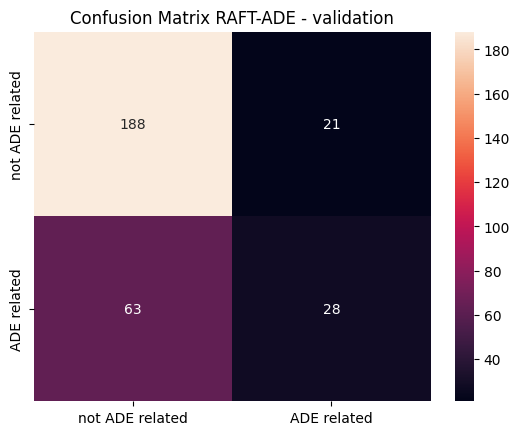

In [156]:
df = pd.DataFrame(
    history['val_conf_matrix'].to("cpu").numpy(),
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - validation")

## Generating Test resukts

In [148]:
model = trainer.best_model
submission = pd.DataFrame()

with torch.no_grad():
    for i in tqdm(range(len(test['text']))):
        text = test['text'][i]
        label = test['label'][i]

        tokens = tokenizer(
            text,
            truncation= True,
            padding= "max_length",
            return_tensors= "pt",
            max_length=256,
        )

        for k,v in tokens.items():
            tokens[k] = v.to(device)

        pred = model(**tokens)\
            .logits\
            .argmax()\
            .to('cpu')\
            .item()

        this_row = pd.DataFrame({"predicted": pred, "label": label}, index = [i])

        submission = pd.concat([submission, this_row],)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 138.57it/s]


In [149]:
submission

,predicted,label
0,0,1
1,0,0
2,1,0
3,0,0
4,0,0
...,...,...
995,0,0
996,0,0
997,1,0
998,0,0


In [152]:
from sklearn.metrics import f1_score, confusion_matrix

In [154]:
f1_score(submission['label'], submission['predicted'])

0.32150313152400833

Text(0.5, 1.0, 'Confusion Matrix RAFT-ADE - test')

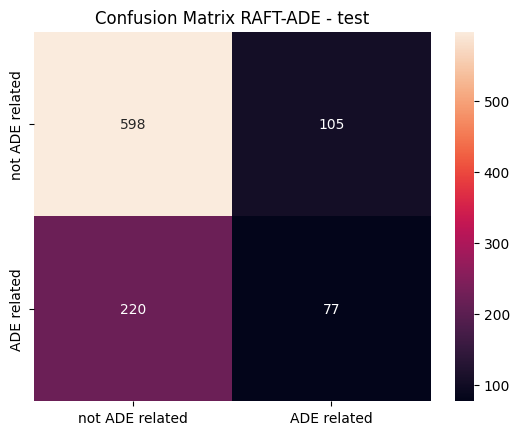

In [157]:
conf_matrix = confusion_matrix(
    submission['label'], 
    submission['predicted']
)

df = pd.DataFrame(
    conf_matrix,
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - test")